In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from collections import defaultdict
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split


In [67]:
df = pd.read_csv("C:/Users/zhao2/OneDrive/Desktop/example data/new_dataset1.csv")

In [44]:
df.head()

,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Description,Transaction_Day,Transaction_Weekday,Time_Category
0,Male,60,Kerala,Thiruvananthapuram,Thiruvananthapuram Branch,Savings,32415.45,Transfer,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,Bitcoin transaction,23,3,Afternoon
1,Female,51,Maharashtra,Nashik,Nashik Branch,Business,43622.60,Bill Payment,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,Grocery delivery,11,5,Evening
2,Male,20,Bihar,Bhagalpur,Bhagalpur Branch,Savings,63062.56,Bill Payment,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,Mutual fund investment,25,5,Night
3,Female,57,Tamil Nadu,Chennai,Chennai Branch,Business,14000.72,Debit,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,Food delivery,19,6,Afternoon
4,Female,43,Punjab,Amritsar,Amritsar Branch,Savings,18335.16,Transfer,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,Debt repayment,30,3,Evening


## Load train and test sets

In [18]:
train = pd.read_csv('c:/Users/zhao2/OneDrive/Desktop/example data/content/processed_train_set.csv')
test = pd.read_csv('c:/Users/zhao2/OneDrive/Desktop/example data/content/processed_train_set.csv')

In [19]:
train.columns

Index(['Age', 'State', 'City', 'Transaction_Amount', 'Merchant_Category',
       'Account_Balance', 'Transaction_Location', 'Device_Type', 'Is_Fraud',
       'Transaction_Description', 'Transaction_Day', 'Transaction_Weekday',
       'Gender_Male', 'Bank_Branch_Branch B', 'Bank_Branch_Branch C',
       'Bank_Branch_Branch D', 'Account_Type_Checking', 'Account_Type_Savings',
       'Transaction_Type_Online', 'Transaction_Type_POS',
       'Transaction_Device_Mobile', 'Transaction_Device_POS Terminal',
       'Transaction_Device_Web', 'Time_Category_Evening',
       'Time_Category_Morning', 'Time_Category_Night'],
      dtype='object')

In [20]:
X_train = train.drop(columns='Is_Fraud')
y_train = train['Is_Fraud']
X_test = test.drop(columns='Is_Fraud')
y_test = test['Is_Fraud']

## Apply SMOTETomek

In [6]:
smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)


In [7]:
df_resampled = pd.DataFrame(X_resampled, columns=train.columns) ## features train
df_resampled['Is_Fraud'] = y_resampled ## Target y
print(df_resampled['Is_Fraud'].value_counts())


Is_Fraud
0    148800
1     74400
Name: count, dtype: int64


**This classification problem is addressed using supervised learning. The following code implements five different models along with the stacking ensemble method. Stacking integrates multiple models, leveraging their strengths to improve performance. In fraud detection, transaction patterns vary.**

## Models and Performance Metrics

In [8]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,  confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, classification_report, auc
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import matplotlib.pyplot as plt

In [9]:
def modelling(X_train, y_train, X_test,y_test):

    ## Define the models
    models  = {
        'Logistic Regression': LogisticRegression(),
        'XBGoost': xgb.XGBClassifier(random_state =42),
        'Light GBM': lgb.LGBMClassifier(class_weight='balanced', random_state= 42),
        'KNeighbors': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'Stacking Ensemble': StackingClassifier(
            estimators=[
                ('xgb', xgb.XGBClassifier( random_state=42)),
                ('lgb', lgb.LGBMClassifier( class_weight='balanced', random_state=42)),
            ],
            final_estimator=LogisticRegression(),
            stack_method='predict_proba')
    }

    ## Define the performance metrics
    results = []
    for model_name, model in models.items():
        print(f"\n🔹 Training {model_name}...\n")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]  # Used for ROC Curve
        
        ## The binary classification problem actually contains the following performance metrics
        roc_auc = np.round(roc_auc_score(y_test, y_prob), 4)  ## ROC score
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = np.round(report["accuracy"], 4) 
        precision = np.round(report["1"]["precision"], 4) ## For classifed to Fraud
        recall = np.round(report["1"]["recall"], 4)  ## For classifed to Fraud
        
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_vals, precision_vals)
        f1_score = np.round(report["1"]["f1-score"], 4)

        results.append({
            "Model": model_name,
            "ROC-AUC Score": roc_auc,
            "Accuracy": accuracy,
            "Precision (Fraud)": precision,
            "Recall (Fraud)": recall,
            "F1 Score (Fraud)": f1_score
        })

    plt.figure(figsize=(10, 5))
    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (ROC AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Fraud Detection Models")
    plt.legend()
    plt.grid()
    plt.show()
    
    results_df = pd.DataFrame(results)
    return results_df



## Train and evaluate the model


🔹 Training Logistic Regression...


🔹 Training XBGoost...


🔹 Training Light GBM...

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 74400, number of negative: 148800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 223200, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

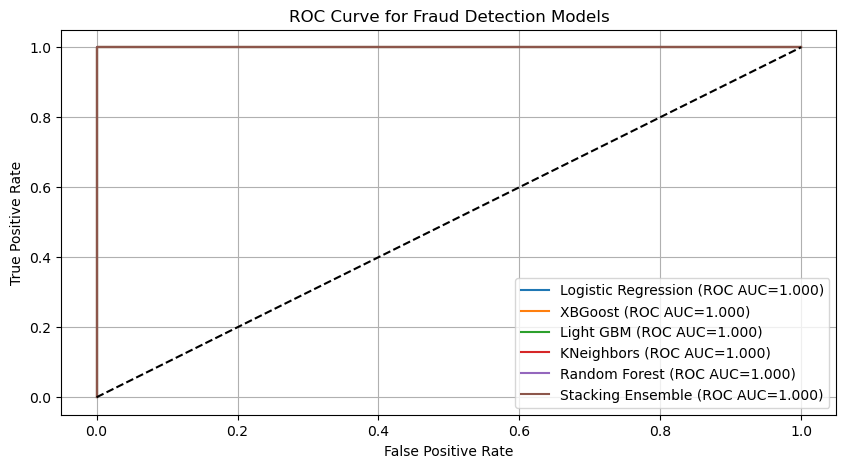

In [10]:
evaluation = modelling(X_resampled, y_resampled, X_test, y_test)

In [11]:
evaluation

,Model,ROC-AUC Score,Accuracy,Precision (Fraud),Recall (Fraud),F1 Score (Fraud)
0,Logistic Regression,1.0,1.0,0.9996,1.0,0.9998
1,XBGoost,1.0,1.0,1.0000,1.0,1.0000
2,Light GBM,1.0,1.0,1.0000,1.0,1.0000
3,KNeighbors,1.0,1.0,1.0000,1.0,1.0000
4,Random Forest,1.0,1.0,1.0000,1.0,1.0000
5,Stacking Ensemble,1.0,1.0,1.0000,1.0,1.0000


In [28]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_resampled,y_resampled)
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Convert to a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    "Feature": X_resampled.columns,
    "Importance": feature_importances
})

# Sort by importance (highest to lowest)
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)


In [29]:
feature_importance_df

,Feature,Importance
3,Transaction_Amount,0.645381
4,Merchant_Category,0.110822
9,Transaction_Day,0.086230
6,Transaction_Location,0.046166
21,Transaction_Device_Web,0.029262
19,Transaction_Device_Mobile,0.027054
20,Transaction_Device_POS Terminal,0.026717
7,Device_Type,0.012402
10,Transaction_Weekday,0.004274
16,Account_Type_Savings,0.003448


In [30]:
## Select features with greater than 0.04 importance
threshold = 0.04
selected_features = feature_importance_df[feature_importance_df["Importance"] > threshold]["Feature"].tolist()

In [31]:
## Refine x_resample and x_test
X_resampled_selected = X_resampled[selected_features]
X_test_selected = X_test[selected_features]


🔹 Training Logistic Regression...


🔹 Training XBGoost...


🔹 Training Light GBM...

[LightGBM] [Info] Number of positive: 74400, number of negative: 148800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 223200, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

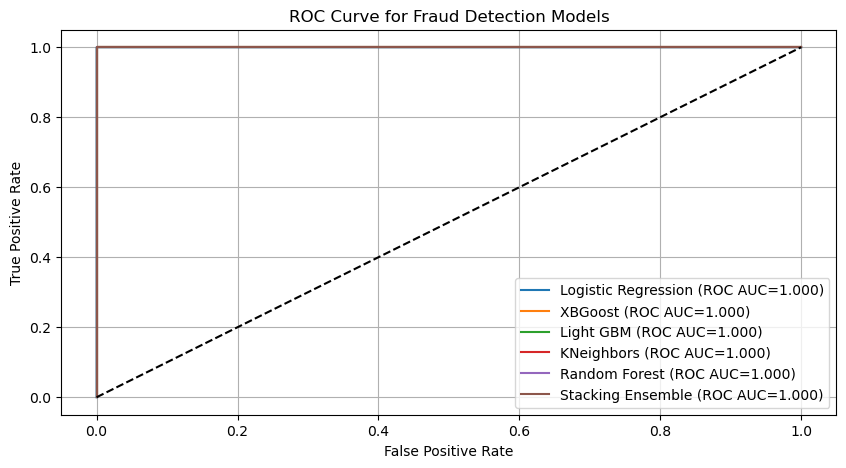

In [32]:
## Use selected features to train the model
results_selected = modelling(X_resampled_selected,y_resampled, X_test_selected, y_test)

In [33]:
results_selected

,Model,ROC-AUC Score,Accuracy,Precision (Fraud),Recall (Fraud),F1 Score (Fraud)
0,Logistic Regression,1.0,1.0,1.0,1.0,1.0
1,XBGoost,1.0,1.0,1.0,1.0,1.0
2,Light GBM,1.0,1.0,1.0,1.0,1.0
3,KNeighbors,1.0,1.0,1.0,1.0,1.0
4,Random Forest,1.0,1.0,1.0,1.0,1.0
5,Stacking Ensemble,1.0,1.0,1.0,1.0,1.0


## Feature Engineering

In [34]:
data = pd.read_csv("C:/Users/zhao2/OneDrive/Desktop/MMA Courses/INSY 695/Bank_Transaction_Fraud_Detection.csv")

In [35]:
df_copy = train
df_copy2 = test

In [36]:
df_copy["amount_to_avg_ratio"] = data["Transaction_Amount"] / data.groupby("Customer_ID")["Transaction_Amount"].transform("mean")
df_copy2["amount_to_avg_ratio"] = data["Transaction_Amount"] / data.groupby("Customer_ID")["Transaction_Amount"].transform("mean")
#df_copy["amount_to_median_ratio"] = data["Transaction_Amount"] / df.groupby("Customer_ID")["Transaction_Amount"].transform("median")
#df["amount_deviation"] = df["transaction_amount"] - df.groupby("user_id")["transaction_amount"].transform("mean")
#df["amount_zscore"] = (df["transaction_amount"] - df.groupby("user_id")["transaction_amount"].transform("mean")) / df.groupby("user_id")["transaction_amount"].transform("std")

In [37]:
df_copy["transactions_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_ID"].transform("count")
df_copy["unique_merchants"] = data.groupby("Customer_ID")["Merchant_ID"].transform("nunique")
#df_copy["unique_categories"] = df.groupby("Customer_ID")["category"].transform("nunique")
df_copy2["transactions_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_ID"].transform("count")
df_copy2["unique_merchants"] = data.groupby("Customer_ID")["Merchant_ID"].transform("nunique")

In [38]:
df_copy["average_spending_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_Amount"].transform("mean")
df_copy["spending_change"] = df_copy["Transaction_Amount"] / df_copy["average_spending_per_day"]
#df_copy["online_transaction_ratio"] = data.groupby("Customer_ID")["Is_Online"].transform("mean")
df_copy2["average_spending_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_Amount"].transform("mean")
df_copy2["spending_change"] = df_copy["Transaction_Amount"] / df_copy["average_spending_per_day"]

In [39]:
df_copy2.head()

,Age,State,City,Transaction_Amount,Merchant_Category,Account_Balance,Transaction_Location,Device_Type,Is_Fraud,Transaction_Description,...,Transaction_Device_POS Terminal,Transaction_Device_Web,Time_Category_Evening,Time_Category_Morning,Time_Category_Night,amount_to_avg_ratio,transactions_per_day,unique_merchants,average_spending_per_day,spending_change
0,55,6,3,82.117696,4,5967.793219,5,2,0,4,...,False,True,False,False,False,1.0,1,1,32415.45,0.002533
1,59,2,1,74.399478,5,2539.502154,3,2,0,3,...,False,False,False,True,False,1.0,1,1,43622.60,0.001706
2,63,2,3,74.908080,0,4239.124607,3,2,0,2,...,False,False,False,False,False,1.0,1,1,63062.56,0.001188
3,48,0,1,540.199955,3,4981.358229,6,0,1,3,...,False,False,True,False,False,1.0,1,1,14000.72,0.038584
4,23,5,5,79.173752,0,6824.554127,1,2,0,2,...,True,False,True,False,False,1.0,1,1,18335.16,0.004318


## Train and evaluate the models again

In [40]:
X_train = df_copy.drop(columns='Is_Fraud')
y_train = df_copy['Is_Fraud']
X_test = df_copy2.drop(columns='Is_Fraud')
y_test = df_copy2['Is_Fraud']

In [41]:
smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
df_resampled = pd.DataFrame(X_resampled, columns=df_copy.columns) ## features df_copy
df_resampled['Is_Fraud'] = y_resampled ## Target y
print(df_resampled['Is_Fraud'].value_counts())

Is_Fraud
0    148800
1     74400
Name: count, dtype: int64


In [42]:
def modelling(X_train, y_train, X_test,y_test):

    ## Define the models
    models  = {
        'Logistic Regression': LogisticRegression(),
        'XBGoost': xgb.XGBClassifier(random_state =42),
        'Light GBM': lgb.LGBMClassifier(class_weight='balanced', random_state= 42),
        'KNeighbors': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'Stacking Ensemble': StackingClassifier(
            estimators=[
                ('xgb', xgb.XGBClassifier( random_state=42)),
                ('lgb', lgb.LGBMClassifier( class_weight='balanced', random_state=42)),
            ],
            final_estimator=LogisticRegression(),
            stack_method='predict_proba')
    }

    ## Define the performance metrics
    results = []
    for model_name, model in models.items():
        print(f"\n🔹 Training {model_name}...\n")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]  # Used for ROC Curve
        
        ## The binary classification problem actually contains the following performance metrics
        roc_auc = np.round(roc_auc_score(y_test, y_prob), 4)  ## ROC score
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = np.round(report["accuracy"], 4) 
        precision = np.round(report["1"]["precision"], 4) ## For classifed to Fraud
        recall = np.round(report["1"]["recall"], 4)  ## For classifed to Fraud
        
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_vals, precision_vals)
        f1_score = np.round(report["1"]["f1-score"], 4)

        results.append({
            "Model": model_name,
            "ROC-AUC Score": roc_auc,
            "Accuracy": accuracy,
            "Precision (Fraud)": precision,
            "Recall (Fraud)": recall,
            "F1 Score (Fraud)": f1_score
        })

    plt.figure(figsize=(10, 5))
    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (ROC AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Fraud Detection Models")
    plt.legend()
    plt.grid()
    plt.show()
    
    results_df = pd.DataFrame(results)
    return results_df




🔹 Training Logistic Regression...


🔹 Training XBGoost...


🔹 Training Light GBM...

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 74400, number of negative: 148800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1191
[LightGBM] [Info] Number of data points in the train set: 223200, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

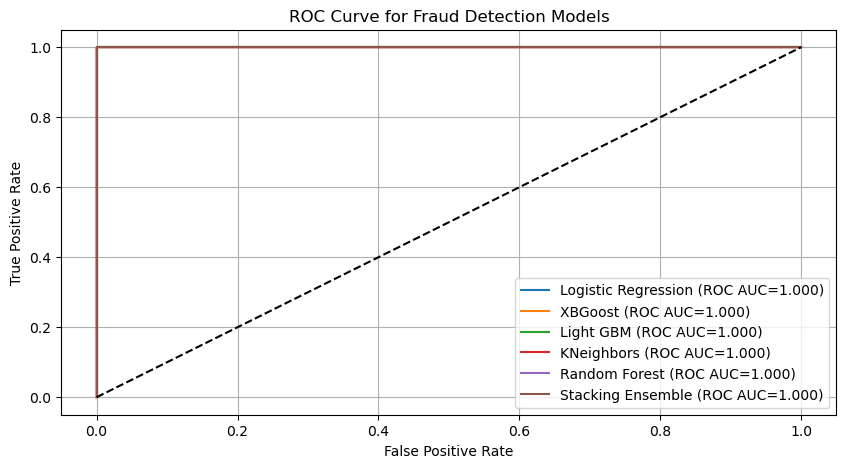

,Model,ROC-AUC Score,Accuracy,Precision (Fraud),Recall (Fraud),F1 Score (Fraud)
0,Logistic Regression,1.0,1.0,0.9997,1.0000,0.9999
1,XBGoost,1.0,1.0,1.0000,1.0000,1.0000
2,Light GBM,1.0,1.0,1.0000,1.0000,1.0000
3,KNeighbors,1.0,1.0,1.0000,0.9994,0.9997
4,Random Forest,1.0,1.0,1.0000,1.0000,1.0000
5,Stacking Ensemble,1.0,1.0,1.0000,1.0000,1.0000


In [43]:
modelling(X_resampled, y_resampled, X_test, y_test)

In [44]:
from sklearn.metrics import precision_recall_curve

## We will switch the X_resample and y_resample  to the original ones using the train and test sets
model = xgb.XGBClassifier(random_state =42)
model.fit(X_resampled, y_resampled)
y_probs = model.predict_proba(X_test)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
optimal_threshold = thresholds[recall.argmax()]  # Choose threshold maximizing recall

y_pred_adjusted = (y_probs > optimal_threshold).astype(int)


In [45]:
roc_auc = roc_auc_score(y_test, y_probs)

# Print Performance Metrics
print(f"🔹 ROC-AUC Score: {roc_auc:.4f}")
print("🔹 Classification Report:\n", classification_report(y_test, y_pred_adjusted))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
print("🔹 Confusion Matrix:\n", conf_matrix)


🔹 ROC-AUC Score: 1.0000
🔹 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    148800
           1       1.00      1.00      1.00     11200

    accuracy                           1.00    160000
   macro avg       1.00      1.00      1.00    160000
weighted avg       1.00      1.00      1.00    160000

🔹 Confusion Matrix:
 [[148800      0]
 [     0  11200]]


In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

In [22]:
# Select only Non-Fraud transactions for Autoencoder Training
X_train_normal = X_train[y_train == 0]  


In [23]:
input_dim = X_train_normal.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu")(input_layer)
encoded = Dense(8, activation="relu")(encoded)
encoded = Dense(4, activation="relu")(encoded)

decoded = Dense(8, activation="relu")(encoded)
decoded = Dense(16, activation="relu")(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded) 

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse") 


In [24]:
autoencoder.fit(X_train_normal, X_train_normal, epochs=50, batch_size=32, shuffle=True, validation_split=0.1, verbose=1)


Epoch 1/50
4185/4185 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 1158261.7500 - val_loss: 1143449.8750
Epoch 2/50
4185/4185 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1159422.0000 - val_loss: 1143449.7500
Epoch 3/50
4185/4185 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 1160804.7500 - val_loss: 1143449.8750
Epoch 4/50
4185/4185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1153638.2500 - val_loss: 1143449.7500
Epoch 5/50
4185/4185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1158688.1250 - val_loss: 1143449.7500
Epoch 6/50
4185/4185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1155243.3750 - val_loss: 1143449.7500
Epoch 7/50
4185/4185 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1157441.6250 - val_loss: 1143449.8750
Epoch 8/50
4185/4185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1156640.8750 - val_loss: 1143449.7500
Epoch 9/50
4185/4185 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1157253.2500 - val_loss: 1143449.8750
Epoch 10/50
4185/4185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1158232.0000 - val_loss: 1143449.8750

In [25]:
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.abs(X_test - X_test_reconstructed), axis=1)

threshold = np.percentile(reconstruction_errors, 95)

y_pred_autoencoder = (reconstruction_errors > threshold).astype(int)


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 3s 513us/step


In [26]:
roc_auc = roc_auc_score(y_test, y_pred_autoencoder)
print(f"🔹 ROC AUC Score: {roc_auc:.4f}")

print("🔹 Classification Report:\n", classification_report(y_test, y_pred_autoencoder))


🔹 ROC AUC Score: 0.5278
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94    148800
           1       0.14      0.10      0.12     11200

    accuracy                           0.89    160000
   macro avg       0.54      0.53      0.53    160000
weighted avg       0.88      0.89      0.89    160000



**Throughout the modeling process, **XGBoost** demonstrated the best performance among all models and methods, achieving an **ROC-AUC score of 0.5104**. Therefore, it has been selected as the preferred model for fraud detection. In the next stage, we will focus on **hyperparameter tuning** to further optimize the model and improve its ROC-AUC score..**

## Save the model and the notebook to github.

In [51]:
xgb_model = xgb.XGBClassifier(random_state =42)


In [53]:
import pickle
with open("C:/Users/zhao2/OneDrive/Desktop/MMA Courses/INSY 695/xgb_fraud_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)


In [55]:
import pickle
with open("lightgbm_fraud_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)